In [1]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
from absl import app, flags, logging
from absl.flags import FLAGS
import core.utils as utils
from core.config import cfg
from core.yolov4 import filter_boxes
from tensorflow.python.saved_model import tag_constants
from PIL import Image
import cv2
import numpy as np
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

2021-10-03 18:38:39.432673: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-10-03 18:38:51.863765: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-10-03 18:38:52.033835: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-03 18:38:52.034917: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.62GHz coreCount: 6 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 104.43GiB/s
2021-10-03 18:38:52.034996: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-10-03 18:38:52.376435: I tensorflow/stream_executor/platfor

In [2]:
flags.DEFINE_string('framework', 'tf', '(tf, tflite, trt')
flags.DEFINE_string('weights', './checkpoints/yolov4-416',
                    'path to weights file')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_boolean('tiny', False, 'yolo or yolo-tiny')
flags.DEFINE_string('model', 'yolov4', 'yolov3 or yolov4')
flags.DEFINE_list('images', './data/images/kite.jpg', 'path to input image')
flags.DEFINE_string('output', './detections/', 'path to output folder')
flags.DEFINE_float('iou', 0.45, 'iou threshold')
flags.DEFINE_float('score', 0.25, 'score threshold')
flags.DEFINE_boolean('dont_show', False, 'dont show image output')


In [3]:
def main(_argv):
    config = ConfigProto()
    config.gpu_options.allow_growth = True
    session = InteractiveSession(config=config)
    STRIDES, ANCHORS, NUM_CLASS, XYSCALE = utils.load_config(FLAGS)
    input_size = FLAGS.size
    images = FLAGS.images

    # load model
    if FLAGS.framework == 'tflite':
            interpreter = tf.lite.Interpreter(model_path=FLAGS.weights)
    else:
            saved_model_loaded = tf.saved_model.load(FLAGS.weights, tags=[tag_constants.SERVING])

    # loop through images in list and run Yolov4 model on each
    for count, image_path in enumerate(images, 1):
        original_image = cv2.imread(image_path)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

        image_data = cv2.resize(original_image, (input_size, input_size))
        image_data = image_data / 255.

        images_data = []
        for i in range(1):
            images_data.append(image_data)
        images_data = np.asarray(images_data).astype(np.float32)

        if FLAGS.framework == 'tflite':
            interpreter.allocate_tensors()
            input_details = interpreter.get_input_details()
            output_details = interpreter.get_output_details()
            print(input_details)
            print(output_details)
            interpreter.set_tensor(input_details[0]['index'], images_data)
            interpreter.invoke()
            pred = [interpreter.get_tensor(output_details[i]['index']) for i in range(len(output_details))]
            if FLAGS.model == 'yolov3' and FLAGS.tiny == True:
                boxes, pred_conf = filter_boxes(pred[1], pred[0], score_threshold=0.25, input_shape=tf.constant([input_size, input_size]))
            else:
                boxes, pred_conf = filter_boxes(pred[0], pred[1], score_threshold=0.25, input_shape=tf.constant([input_size, input_size]))
        else:
            infer = saved_model_loaded.signatures['serving_default']
            batch_data = tf.constant(images_data)
            pred_bbox = infer(batch_data)
            for key, value in pred_bbox.items():
                boxes = value[:, :, 0:4]
                pred_conf = value[:, :, 4:]

        boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
            boxes=tf.reshape(boxes, (tf.shape(boxes)[0], -1, 1, 4)),
            scores=tf.reshape(
                pred_conf, (tf.shape(pred_conf)[0], -1, tf.shape(pred_conf)[-1])),
            max_output_size_per_class=50,
            max_total_size=50,
            iou_threshold=FLAGS.iou,
            score_threshold=FLAGS.score
        )
        pred_bbox = [boxes.numpy(), scores.numpy(), classes.numpy(), valid_detections.numpy()]

        # read in all class names from config
        class_names = utils.read_class_names(cfg.YOLO.CLASSES)

        # by default allow all classes in .names file
        allowed_classes = list(class_names.values())
        
        # custom allowed classes (uncomment line below to allow detections for only people)
        #allowed_classes = ['person']

        image = utils.draw_bbox(original_image, pred_bbox, allowed_classes = allowed_classes)

        image = Image.fromarray(image.astype(np.uint8))
        if not FLAGS.dont_show:
            image.show()
        image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)
        cv2.imwrite(FLAGS.output + 'detection' + str(count) + '.png', image)


In [2]:
class Flags1:
    def __init__(self):
        self.framework='tf'
        self.weights='./checkpoints/yolov4-416'
        self.size=416
        self.tiny= False#, 'yolo or yolo-tiny')
        self.model='yolov4'#, 'yolov3 or yolov4')
        self.images= ["./data/images/pdcofigchair/h1.jpg",]#, 'path to input image')
        self.output= './detections' # 'path to output folder')
        self.iou= 0.45
        self.score= 0.25
        self.dont_show= False
    def myfunc(self):        
        print("Hello my func ")

In [3]:
FLAGS=Flags1()

In [4]:
def test():
    config = ConfigProto()
    config.gpu_options.allow_growth = True
    session = InteractiveSession(config=config)
    STRIDES, ANCHORS, NUM_CLASS, XYSCALE = utils.load_config(FLAGS)
    input_size = FLAGS.size
    images = FLAGS.images
    plist=list()

    # load model
    if FLAGS.framework == 'tflite':
            interpreter = tf.lite.Interpreter(model_path=FLAGS.weights)
    else:
            saved_model_loaded = tf.saved_model.load(FLAGS.weights, tags=[tag_constants.SERVING])

    # loop through images in list and run Yolov4 model on each
    for count, image_path in enumerate(images, 1):
        print(count,image_path)
        original_image = cv2.imread(image_path)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

        image_data = cv2.resize(original_image, (input_size, input_size))
        image_data = image_data / 255.

        images_data = []
        for i in range(1):
            images_data.append(image_data)
        images_data = np.asarray(images_data).astype(np.float32)

        if FLAGS.framework == 'tflite':
            interpreter.allocate_tensors()
            input_details = interpreter.get_input_details()
            output_details = interpreter.get_output_details()
            print(input_details)
            print(output_details)
            interpreter.set_tensor(input_details[0]['index'], images_data)
            interpreter.invoke()
            pred = [interpreter.get_tensor(output_details[i]['index']) for i in range(len(output_details))]
            if FLAGS.model == 'yolov3' and FLAGS.tiny == True:
                boxes, pred_conf = filter_boxes(pred[1], pred[0], score_threshold=0.25, input_shape=tf.constant([input_size, input_size]))
            else:
                boxes, pred_conf = filter_boxes(pred[0], pred[1], score_threshold=0.25, input_shape=tf.constant([input_size, input_size]))
        else:
            infer = saved_model_loaded.signatures['serving_default']
            batch_data = tf.constant(images_data)
            pred_bbox = infer(batch_data)
            for key, value in pred_bbox.items():
                boxes = value[:, :, 0:4]
                pred_conf = value[:, :, 4:]

        boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
            boxes=tf.reshape(boxes, (tf.shape(boxes)[0], -1, 1, 4)),
            scores=tf.reshape(
                pred_conf, (tf.shape(pred_conf)[0], -1, tf.shape(pred_conf)[-1])),
            max_output_size_per_class=50,
            max_total_size=50,
            iou_threshold=FLAGS.iou,
            score_threshold=FLAGS.score
        )
        
        pred_bbox = [boxes.numpy(), scores.numpy(), classes.numpy(), valid_detections.numpy()]
        print(boxes.numpy()[0])
        coor = pred_bbox[0][0][1]
        image_h, image_w, _ = original_image.shape
        coor[0] = int(coor[0] * image_h)
        coor[2] = int(coor[2] * image_h)
        coor[1] = int(coor[1] * image_w)
        coor[3] = int(coor[3] * image_w)
        #ymin,xmin,ymax,xmax=np.array(boxes[0][0]).astype(int)
        #crop=original_image[ymin-5:ymax+5 , xmin-5:xmax+5]
        print(coor[0],coor[2],coor[1],coor[3])
        #crop=original_image[int(coor[0]):int(coor[2]),int(coor[1]):int(coor[3])]
        crop=original_image[0:480,0:640]

        # read in all class names from config
        class_names = utils.read_class_names(cfg.YOLO.CLASSES)

        # by default allow all classes in .names file
        allowed_classes = list(class_names.values())
        
        # custom allowed classes (uncomment line below to allow detections for only people)
        #allowed_classes = ['person']

        image = utils.draw_bbox(original_image, pred_bbox, allowed_classes = allowed_classes)

        image = Image.fromarray(image.astype(np.uint8))
        crop  = Image.fromarray(crop.astype(np.uint8))
        if not FLAGS.dont_show:
            image.show()
            crop.show()
        image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)
        cv2.imwrite(FLAGS.output + 'detection' + str(count) + '.png', image)
        return boxes
        


In [5]:
if __name__ == '__main__':
    try:
        app.run(test)
    except SystemExit:
        pass

FATAL Flags parsing error: Unknown command line flag 'f'
Pass --helpshort or --helpfull to see help on flags.


In [6]:
a=test()

2021-10-03 18:39:01.286914: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-03 18:39:01.287795: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.62GHz coreCount: 6 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 104.43GiB/s
2021-10-03 18:39:01.287874: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-10-03 18:39:01.287924: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-10-03 18:39:01.287965: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2021-10-03 18:39:01.288017: I tensorflow/stream_executor/platfor

1 ./data/images/pdcofigchair/h1.jpg


2021-10-03 18:39:24.555776: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2021-10-03 18:39:33.470322: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-10-03 18:39:35.601647: W tensorflow/core/common_runtime/bfc_allocator.cc:312] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


[[0.30070677 0.27770653 0.84117204 0.6625581 ]
 [0.79305667 0.00624935 1.         1.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         

In [7]:
image = cv2.imread(FLAGS.images[0])

In [8]:
image.shape

(480, 640, 3)

In [9]:
image_h, image_w, _ = image.shape

In [55]:
coor=a[0][0].numpy()

In [56]:
a[0][0].numpy()

array([0.30070677, 0.27770653, 0.84117204, 0.6625581 ], dtype=float32)

In [57]:
coor

array([0.30070677, 0.27770653, 0.84117204, 0.6625581 ], dtype=float32)

In [58]:
coor[1] * image_h

133.2991361618042

In [59]:
coor[3] * image_h

318.0278778076172

In [60]:
coor[0] = int(coor[0] * image_h)
coor[2] = int(coor[2] * image_h)
coor[1] = int(coor[1] * image_w)
coor[3] = int(coor[3] * image_w)

In [61]:
c1, c2 = (coor[1], coor[0]), (coor[2], coor[3])

In [76]:
hmin= int(coor[0])
hmax = int(coor[2])
wmin = int(coor[1])
wmax = int(coor[3])

In [63]:
c1,c2

((177.0, 144.0), (403.0, 424.0))

In [72]:
crop=image[int(coor[0]):int(coor[2]),int(coor[1]):int(coor[3])]

In [73]:
print(hmax,hmin,wmax,wmin,sep="\n")

424
177
403
144


In [74]:
crop  = Image.fromarray(crop.astype(np.uint8))

In [75]:
crop.show()

In [78]:
from matplotlib import pyplot as plt
%matplotlib inline

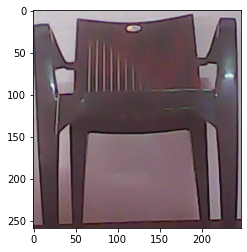

In [79]:
plt.imshow(cv2.cvtColor(image[hmin:hmax,wmin:wmax], cv2.COLOR_BGR2RGB))
plt.show()